# Tutorial # 4 -- Burchett et al 2021 + cold streams

*** Before running anything, compile the code by typing `make` in the local (`tutorial_4`) directory. This will compile the RASCAS codes using the local `module_idealised_model.f90` code which implements (some of) Burchett's model. ***

In this tutorial we run the models of Burchett et al 2021 (taken from Prochaska+11) which have the following properties. 

The density profile is $n(r) = n_0 (r_{inner}/r)^2$

The velocity profile is $v(r) = v_{in} + (r - r_{inner})/(r_{outer} - r_{inner}) * (v_{outer} - v_{inner})$

# Setup and imports 

In [1]:
# First a few necessary setups
RascasDir = '../../'  # Where you have your rascas clone.
ExperimentDir = './'  # where the RASCAS run will happen (and where param file will be written). 
atomic_data_dir = '%s/ions_parameters/'%(RascasDir)  # path to the rascas-SaasFee/ions_parameters directory.

# use a parallel environment or not
useMPI = True

# include rascas/py in the path for imports 
import sys
sys.path.append("../../py/")
# imports from rascas/py
import write_param_files as wpf
import jphot as jp
import lya_utils as lya

# 
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# Units ... TBC... 
import astropy.units as u
from astropy.constants import c

# 1. Definition of parameters

## 1.1. Model parameters 

### 1.1.1. Gas properties 

In [2]:
# Physical properties of the model
r_inner_kpc = 2.0 
r_outer_kpc = 20.0
v_inner_kms = 50.0
v_outer_kms = 500.0
nH_norm_cgs = 3e-7 # [cm-3] this is actually the volume number density 
                   # of scatterers (i.e. MgII ions by default here) 
Temperature = 1e4  # temperature of the gas. [K]
TurbulentVelocity_kms = 15.0 # turbulent velocity of the gas. [km/s]

        
# cold streams  --- Set number of them, and draw random directions ... 
if True:
    nb_of_cold_streams = 3
    # define random directions (smapling the sphere uniformly)
    phi = np.random.rand(nb_of_cold_streams) * 2 * np.pi
    cosp = np.cos(phi)
    sinp = np.sin(phi)
    cost = np.random.rand(nb_of_cold_streams) * 2 - 1.0
    sint = np.sqrt(1. - cost**2) 
    stream_kx = sint * cosp
    stream_ky = sint * sinp
    stream_kz = cost
else:
    nb_of_cold_streams = 2
    stream_kx = [0.1,0.1]
    stream_ky = [1,-1]
    stream_kz = [0,0]
cold_stream_covering_fraction = 0.01
cold_stream_to_outflow_nH_ratio = 100.
v_out_cone_kms = -50.
v_in_cone_kms  = -100.
        
# We should also specify the number and nature of the scatterer(s) (i.e. of the absorption line(s))
nscatterer = 2
scatterer_names = 'MgII-2796, MgII-2804'


### 1.1.2. Properties of the radiation source 

NB: radiation is emitted from a point source at rest at the center of the computational box.

In [3]:
# Definition of the spectral shape
spec_type            = 'PowLaw'   # We emit a power-law 
spec_powlaw_lmin_Ang = 2788       # from lambda = spec_powlaw_lmin_Ang   [Angstrom]
spec_powlaw_lmax_Ang = 2809       # to lambda = spec_powlaw_lmax_Ang     [Angstrom]
spec_powlaw_beta     = -2.0       # with slope spec_powlaw_beta (-2 means flat in F_lambda)

# Number of photon packets for the Monte Carlo experiment 
nPhotonPackets       = 100000


### 1.1.3. Numerical parameters 
These define how we will generate an adaptive mesh etc. 

In [4]:
refine_lmax        = 8      # no need for refinement with a homogeneous medium ... 
refine_err_grad_d  = 0.05   # will trigger refinement on density fluctuations (if above 10% level)

### 1.1.4. Parameters for mocks (with peeling off)

In [5]:
# Here we need to specify the properties of the mocks we wish to construct, in terms of aim (coords 
# of target and direction of observation) and in terms of observation (photometry, spectroscopy, 
# imaging, 3D spectroscopy). This is done through parameters which need to be written to a file. 

# We start by setting up one pointing and defining the observations for it. 
target_position = np.array([0.5,0.5,0.5])  # aim for the center of the box (all in box units here... )
kobs = np.array([0,-1,0])  # observe along the y direction (make sure k is normalised)

# now, let's add a spectroscopic observation
npix = 200 # the nb of wavelength bins
aperture = 1. # the radius of the circular aperture within which photon packets are collected (in box-size units)
lambda_min = 2788  # min wavelength (Angstrom)
lambda_max = 2809  # max wavelength (Angstrom)
spec = wpf.specParams(npix,aperture,lambda_min,lambda_max)

# let's make an image as well ... 
npix = 200 # nb of pixels on a side
size = 1   # size of the image (side)
image = wpf.imageParams(npix,size)

# let's make a cube 
cube_lbda_npix  = 200
cube_image_npix = 200
cube_lmin = 2788
cube_lmax = 2809
cube_side = 1
cube = wpf.cubeParams(cube_lbda_npix,cube_image_npix,cube_lmin,cube_lmax,cube_side)

# define the object containing all the above information
p = wpf.pointing(kobs,target_position,spec=spec,image=image,cube=cube)

# and write it into some file 
mock_params_file = '%s/mock_param_file.txt'%ExperimentDir
f = open(mock_params_file,'w')
p.write(f)
f.close()

## 1.2. Setting up the parameter file

Parameters need to be provided for different sections of the code. We build a list of sections in the variable `Parameters` and fill it up.


In [6]:
Parameters = []  # initialise a list of parameter sections

# Geometry
section = 'CreateDomDump'
params = {
    'DomDumpDir'       : ExperimentDir,
    'idealised_models' : 'T',
    'comput_dom_type'  : 'sphere',
    'comput_dom_pos'   : '0.5,0.5,0.5',
    'comput_dom_rsp'   : '0.4'  # not 0.5 to avoid periodic boundary condition issues
}
Parameters.append(wpf.param_section(section,params))

# Mesh
section = 'mesh'
params = {
    'verbose'       : 'T',
    'refine_lmax'   : '%i'%(refine_lmax),   
    'refine_err_grad_d'  : '%.2f'%(refine_err_grad_d),
    'refine_err_grad_v'  : '0.05',
    'refine_dv_over_vth' : 'F',
}
Parameters.append(wpf.param_section(section,params))

# Gas composition
section = 'gas_composition'
params = {
    'nscatterer'       : '%i'%(nscatterer), 
    'scatterer_names'  : scatterer_names,
    'atomic_data_dir'   : atomic_data_dir,
    'ignoreDust': 'T'
}
Parameters.append(wpf.param_section(section,params))

# dust properties (unused initially ... )
section = 'dust'
params = {
    'albedo':0.32,
    'g_dust':0.73,
    'dust_model':'SMC'
}
Parameters.append(wpf.param_section(section,params))

# CGM model parameter
section = 'IdealisedModel'
stream_dirs = ""
for i in range(nb_of_cold_streams):
    stream_dirs=stream_dirs+"%.8f  %.8f  %.8f  "%(stream_kx[i],stream_ky[i],stream_kz[i])
params ={
    'nH_norm_cgs':'%.5e'%nH_norm_cgs,   # [cm^-3]
    'r_inner_kpc': '%.5e'%r_inner_kpc,  # [kpc]
    'r_outer_kpc': '%.5e'%r_outer_kpc,  # [kpc]
    'v_inner_kms': '%.5e'%v_inner_kms,  # [km/s]
    'v_outer_kms': '%.5e'%v_outer_kms,  # [km/s]
    'Temperature': '%e'%Temperature,    # [T]
    'TurbulentVelocity_kms': '%f'%TurbulentVelocity_kms, # [km/s]
    'cold_stream_covering_fraction': '%f'%cold_stream_covering_fraction,
    'cold_stream_to_outflow_nH_ratio': '%f'%cold_stream_to_outflow_nH_ratio,
    'v_out_cone_kms': '%f'%v_out_cone_kms, # [km/s]
    'v_in_cone_kms': '%f'%v_in_cone_kms,   # [km/s]
    'nb_of_cold_streams':'%i'%nb_of_cold_streams,
    'cold_stream_directions':stream_dirs
}
Parameters.append(wpf.param_section(section,params))


# Source model
section = 'PhotonsFromSourceModel'
params ={
    'outputfile' : '%s/ppic.dat'%ExperimentDir,
    'source_pos' : '0.5,0.5,0.5',
    'source_vel' : '0,0,0',        # cm/s
    'source_type': 'pointlike',
    'spec_type'  : spec_type,
    'spec_powlaw_lmin_Ang' : '%f'%(spec_powlaw_lmin_Ang),
    'spec_powlaw_lmax_Ang' : '%f'%(spec_powlaw_lmax_Ang),
    'spec_powlaw_beta'     : '%f'%(spec_powlaw_beta),
    'nPhotonPackets'       : '%i'%(nPhotonPackets)
}
Parameters.append(wpf.param_section(section,params))


# RASCAS
if useMPI:
    section = 'rascas' 
else:
    section = 'rascas-serial' 
nbundle = min(nPhotonPackets/100,1000)
params ={
    'verbose':'T',
    'DomDumpDir':ExperimentDir,
    'PhotonICFile':'%s/ppic.dat'%ExperimentDir,
    'fileout':'%s/result.dat'%ExperimentDir,
    'nbundle':'%i'%nbundle
}
Parameters.append(wpf.param_section(section,params))


## WORKER (if MPI)
if useMPI:
    section='worker'
    params={'verbose':'T'}
    Parameters.append(wpf.param_section(section,params))
    

### MOCK -- peeling off
section='mock'
params = {
    'nDirections':'1', 
    'mock_parameter_file':'%s'%mock_params_file,
    'mock_outputfilename':'%s/mock'%ExperimentDir
}
Parameters.append(wpf.param_section(section,params))


#### write parameter list to a file 
wpf.write_parameter_file('%s/params.cfg'%(ExperimentDir),Parameters)

# 2.  Run the codes

## 2.1 create mesh and visualize it

Execute the following cell in order run the executable `CreateDomDumpAMRModel` which generates the adaptive mesh containing the model. This will generate a few files in the `ExperimentDir`, including a log file `CreateDomDumpAMRModel.log`, the `.mesh` file (which has the data) and some `.dom` files which describe different domains. 

In [7]:
# run CreateDomDumpAMRModel
cmd = "./CreateDomDumpAMRModel params.cfg > CreateDomDumpAMRModel.log"
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file CreateDomDumpAMRModel.log or message below for more info')

In [8]:
# visualise the mesh 



## 2.2 create the photon packets

In [9]:
# run PhotonsFromSourceModel
cmd = "./PhotonsFromSourceModel params.cfg > PhotonsFromSourceModel.log"
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file PhotonsFromSourceModel.log or message below for more info')

## 2.3 Run the radiative transfer

In [23]:
# run RASCAS 
if useMPI:
    cmd = "time mpirun ./rascas params.cfg > rascas.log"
else:
    cmd = "time ./rascas-serial params.cfg > rascas.log"
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file rascas.log or message below for more info')


real	0m4.680s
user	0m33.022s
sys	0m0.722s


# 3. Plot the results 

## 3.1. results from photon packets

### 3.1.1. Spectrum (angle-averaged and spatially integrated)

In [11]:
# load the results of the RASCAS experiment
p = jp.photonlist('%s/ppic.dat'%ExperimentDir,'%s/result.dat'%ExperimentDir)

In [12]:
# get the observed spectrum
lobs,sobs = p.spectrum(frame='obs',nbins=200,lmin=2788,lmax=2809)

# get the intrinsic spectrum
lint,sint = p.spectrum(frame='ic',nbins=200,lmin=2788,lmax=2809)

In [13]:
# normalise spectra to the median value of the intrinsic spectrum
continuum = np.median(sint)
sobs = sobs / continuum
sint = sint / continuum

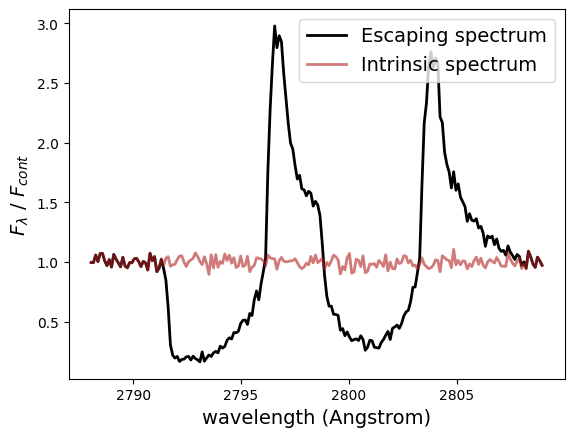

In [14]:
# plot spectra 
plt.plot(lobs,sobs,label='Escaping spectrum',lw=2,ls='-',c='k')
plt.plot(lint,sint,alpha=0.6,label='Intrinsic spectrum',lw=2,ls='-',c='firebrick')
plt.legend(fontsize=14)
plt.xlabel('wavelength (Angstrom)',fontsize=14)
plt.ylabel(r'$F_\lambda\ /\ F_{cont}$',fontsize=14)
plt.show()

### 3.1.2. Surface-brightness profile (angle-averaged)

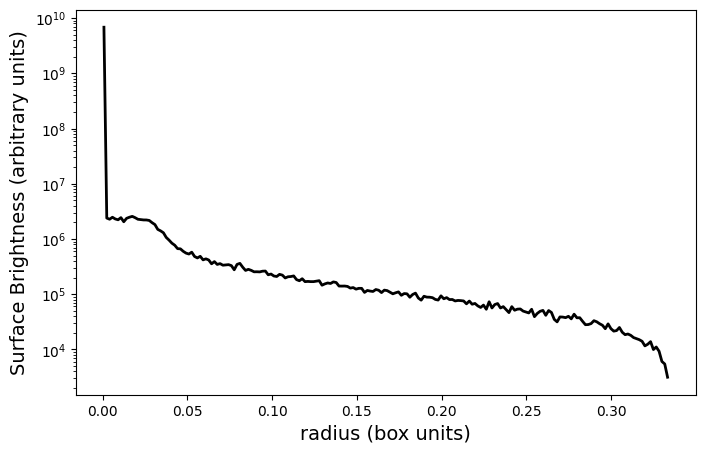

In [24]:
# compute angle-averaged projected radius
rp = p.projected_radius(xc=0.5,yc=0.5,zc=0.5)

# compute SB profile
h,edges = np.histogram(rp,bins=200)
bin_centers = 0.5*(edges[:-1]+edges[1:])
dr = bin_centers[1]-bin_centers[0]
h = h / (2.*np.pi*bin_centers*dr)
# SB in arbitrary units (number of photon packets per annulus area, in box units)

# plot SB profile
plt.figure(figsize=(8,5))
plt.plot(bin_centers,h, lw=2,ls='-',c='k')
plt.yscale('log')
#plt.plot(edges[:-1],np.log10(h))
plt.xlabel('radius (box units)',fontsize=14)
plt.ylabel('Surface Brightness (arbitrary units)',fontsize=14)
plt.show()

### 3.1.3. Spatially resolved spectrum (angle-averaged)

In [16]:
# select and extract photon packets escaping from the inner region
iiIN = np.where(rp < 0.001)
pIN = p.extract_sample(iiIN)
lIN,sIN = pIN.spectrum(frame='obs',nbins=200,lmin=2788,lmax=2809)
sIN /= continuum

iiMID = np.where((rp < 0.03) & (rp >= 0.001))
pMID = p.extract_sample(iiMID)
lMID,sMID = pMID.spectrum(frame='obs',nbins=200,lmin=2788,lmax=2809)
sMID /= continuum

# select and extract photon packets escaping from the outer region (CGM)
iiCGM = np.where(rp>=0.03)
pCGM = p.extract_sample(iiCGM)
lCGM,sCGM = pCGM.spectrum(frame='obs',nbins=200,lmin=2788,lmax=2809)
sCGM /= continuum

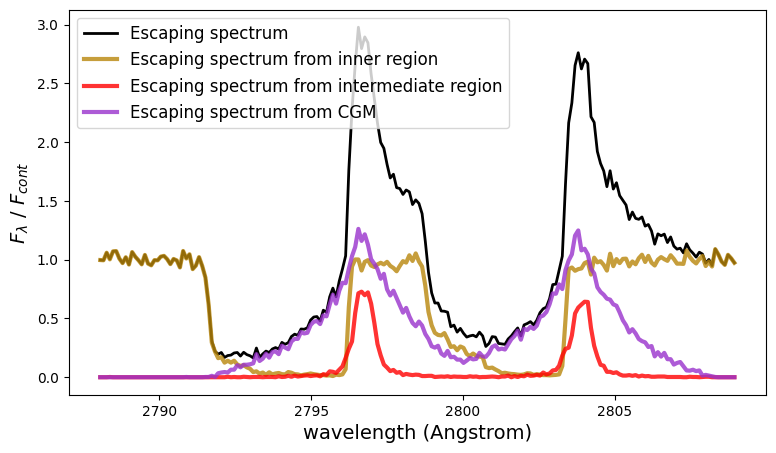

In [17]:
# plot spectra 
plt.figure(figsize=(9,5))
plt.plot(lobs,sobs,label='Escaping spectrum',lw=2,ls='-',c='k')
#plt.plot(lint,sint,alpha=0.6,label='Intrinsic spectrum',lw=2,ls='-',c='firebrick')
plt.plot(lIN,sIN,alpha=0.8,label='Escaping spectrum from inner region',lw=3,ls='-',c='darkgoldenrod')
plt.plot(lMID,sMID,alpha=0.8,label='Escaping spectrum from intermediate region',lw=3,ls='-',c='red')
plt.plot(lCGM,sCGM,alpha=0.8,label='Escaping spectrum from CGM',lw=3,ls='-',c='darkorchid')
plt.legend(fontsize=12)
plt.xlabel('wavelength (Angstrom)',fontsize=14)
plt.ylabel(r'$F_\lambda\ /\ F_{cont}$',fontsize=14)
plt.show()

## 3.2. Peeling off results 

In [18]:
from mocks import mockobs
m = mockobs('./','mock','./ppic.dat',load_spectrum=True,load_image=True)

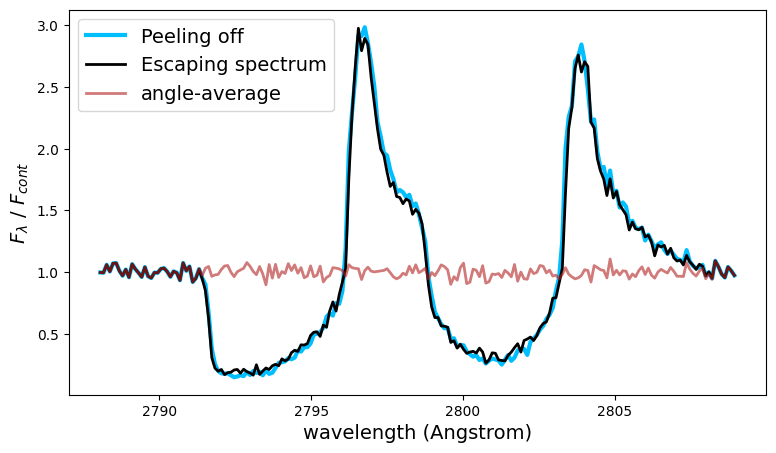

In [19]:
plt.figure(figsize=(9,5))
plt.plot(m.spec_lbda_Angstrom,m.spec/continuum,lw=3,c='deepskyblue',label='Peeling off')
plt.plot(lobs,sobs,label='Escaping spectrum',lw=2,ls='-',c='k')
plt.plot(lint,sint,alpha=0.6,label='angle-average',lw=2,ls='-',c='firebrick')
plt.legend(fontsize=14,loc='upper left')
plt.xlabel('wavelength (Angstrom)',fontsize=14)
plt.ylabel(r'$F_\lambda\ /\ F_{cont}$',fontsize=14)
plt.show()

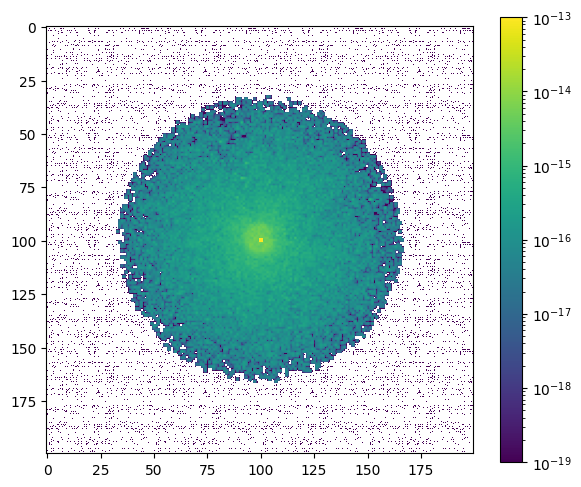

In [20]:
m.show_image(smooth=False,vmin=1e-19,vmax=1e-13) 

In [21]:
# look at the cube now ... 
m = mockobs('./','mock','./ppic.dat',load_cube=True)

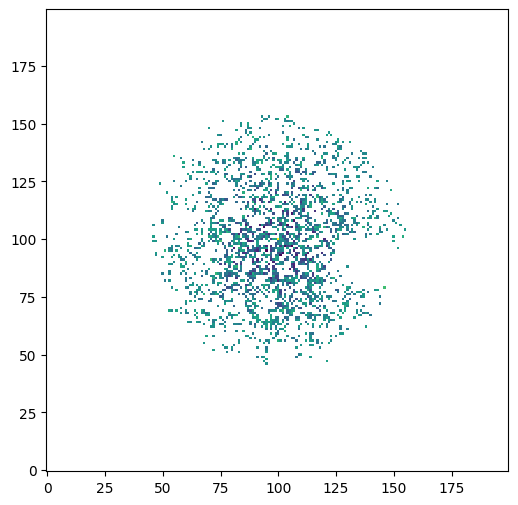

In [22]:
# cut out a slice
#selection = (m.cube_lbda_Angstrom > 2797) & (m.cube_lbda_Angstrom < 2798)
selection = (m.cube_lbda_Angstrom > 2793) & (m.cube_lbda_Angstrom < 2794)
image = np.sum(m.cube[:,:,selection],axis=2) * m.cube_dlbda_Angstrom
plt.figure(figsize=(6,6))
plt.imshow(image,norm=LogNorm(),origin='lower', interpolation='nearest')